In [1]:
import os
import seaborn as sns
import numpy as np
from graph_class import *
from nltk_class import *

In [2]:
with open('twitter.json', 'r') as file:
    tweet = pd.DataFrame(json.load(file))

In [3]:
nlp = NltkTextProcessing()
tweet_df = nlp.process_df_text_column(tweet, save=False)
tweet_df = nlp.process_df_hash_column(tweet_df)
unique_df = nlp.keep_unique(tweet_df)
unique_df.head(1)

,created_at,id,tweet_text,is_reply,reply_count,retweet_count,hashtags,external_url,author_followers,author_follow,author_loc,media_text
0,2021-08-21 10:22:57,1429026229592764417,"[oltre, milioni, ebrei, militari, rom, omosess...",False,0,0,None,https://twitter.com/i/web/status/1429026229592...,527,951,Roma,None


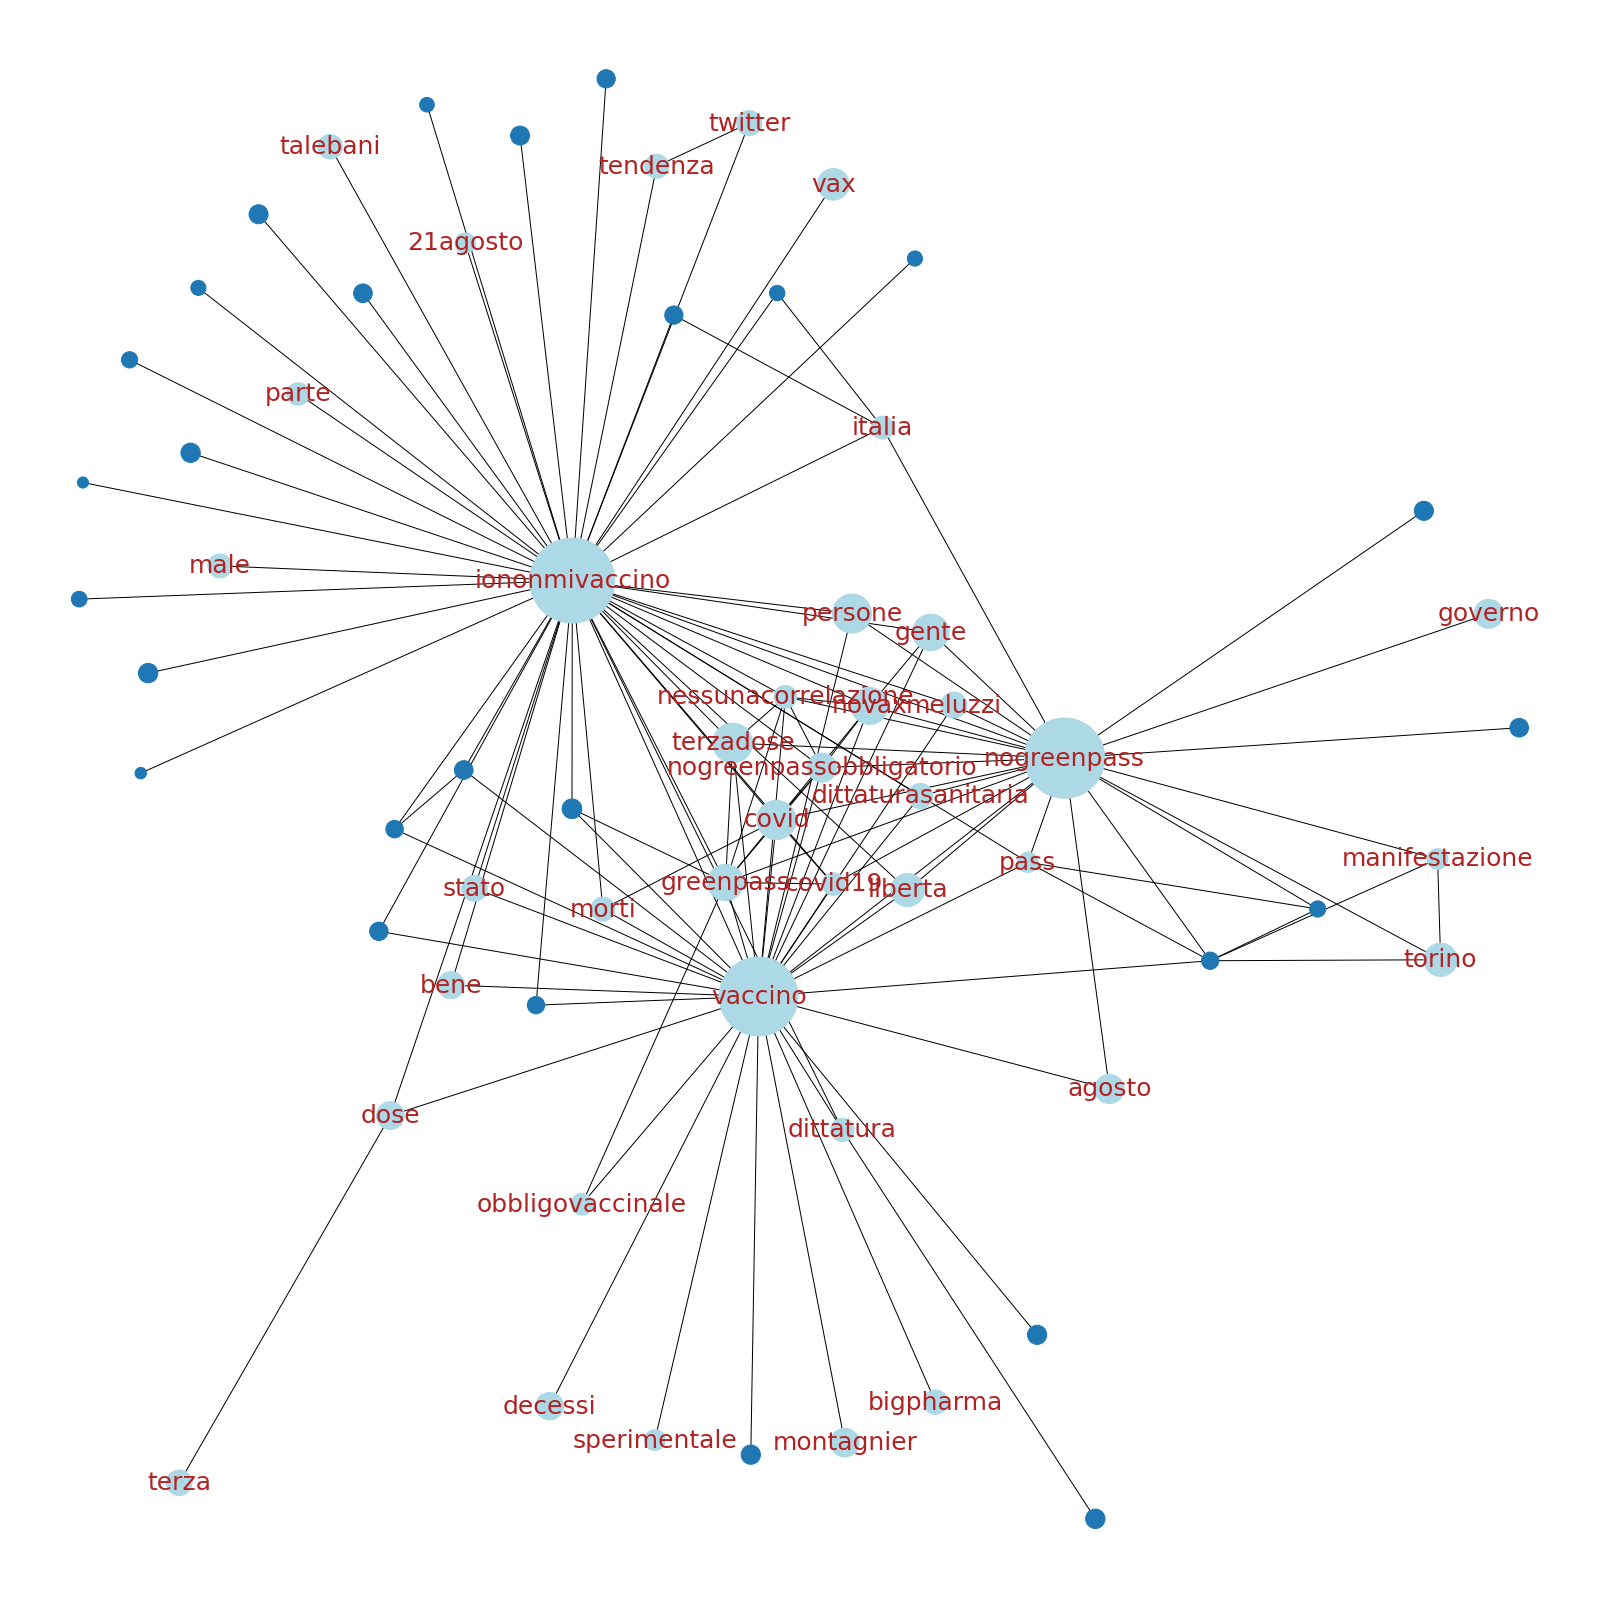

In [4]:
freq_distrib_tweet = nlp.frequency_dist(tweet_df, obj ='tweet')
graph_tweet = filter_pairwise_words(graph_filtered_dist(df=unique_df, distrib=freq_distrib_tweet, thresold=200), thresold=40)
NetworkPlot(graph=graph_tweet, frequency_dist=freq_distrib_tweet, label_thresold=400, color_thresold=400).plot()

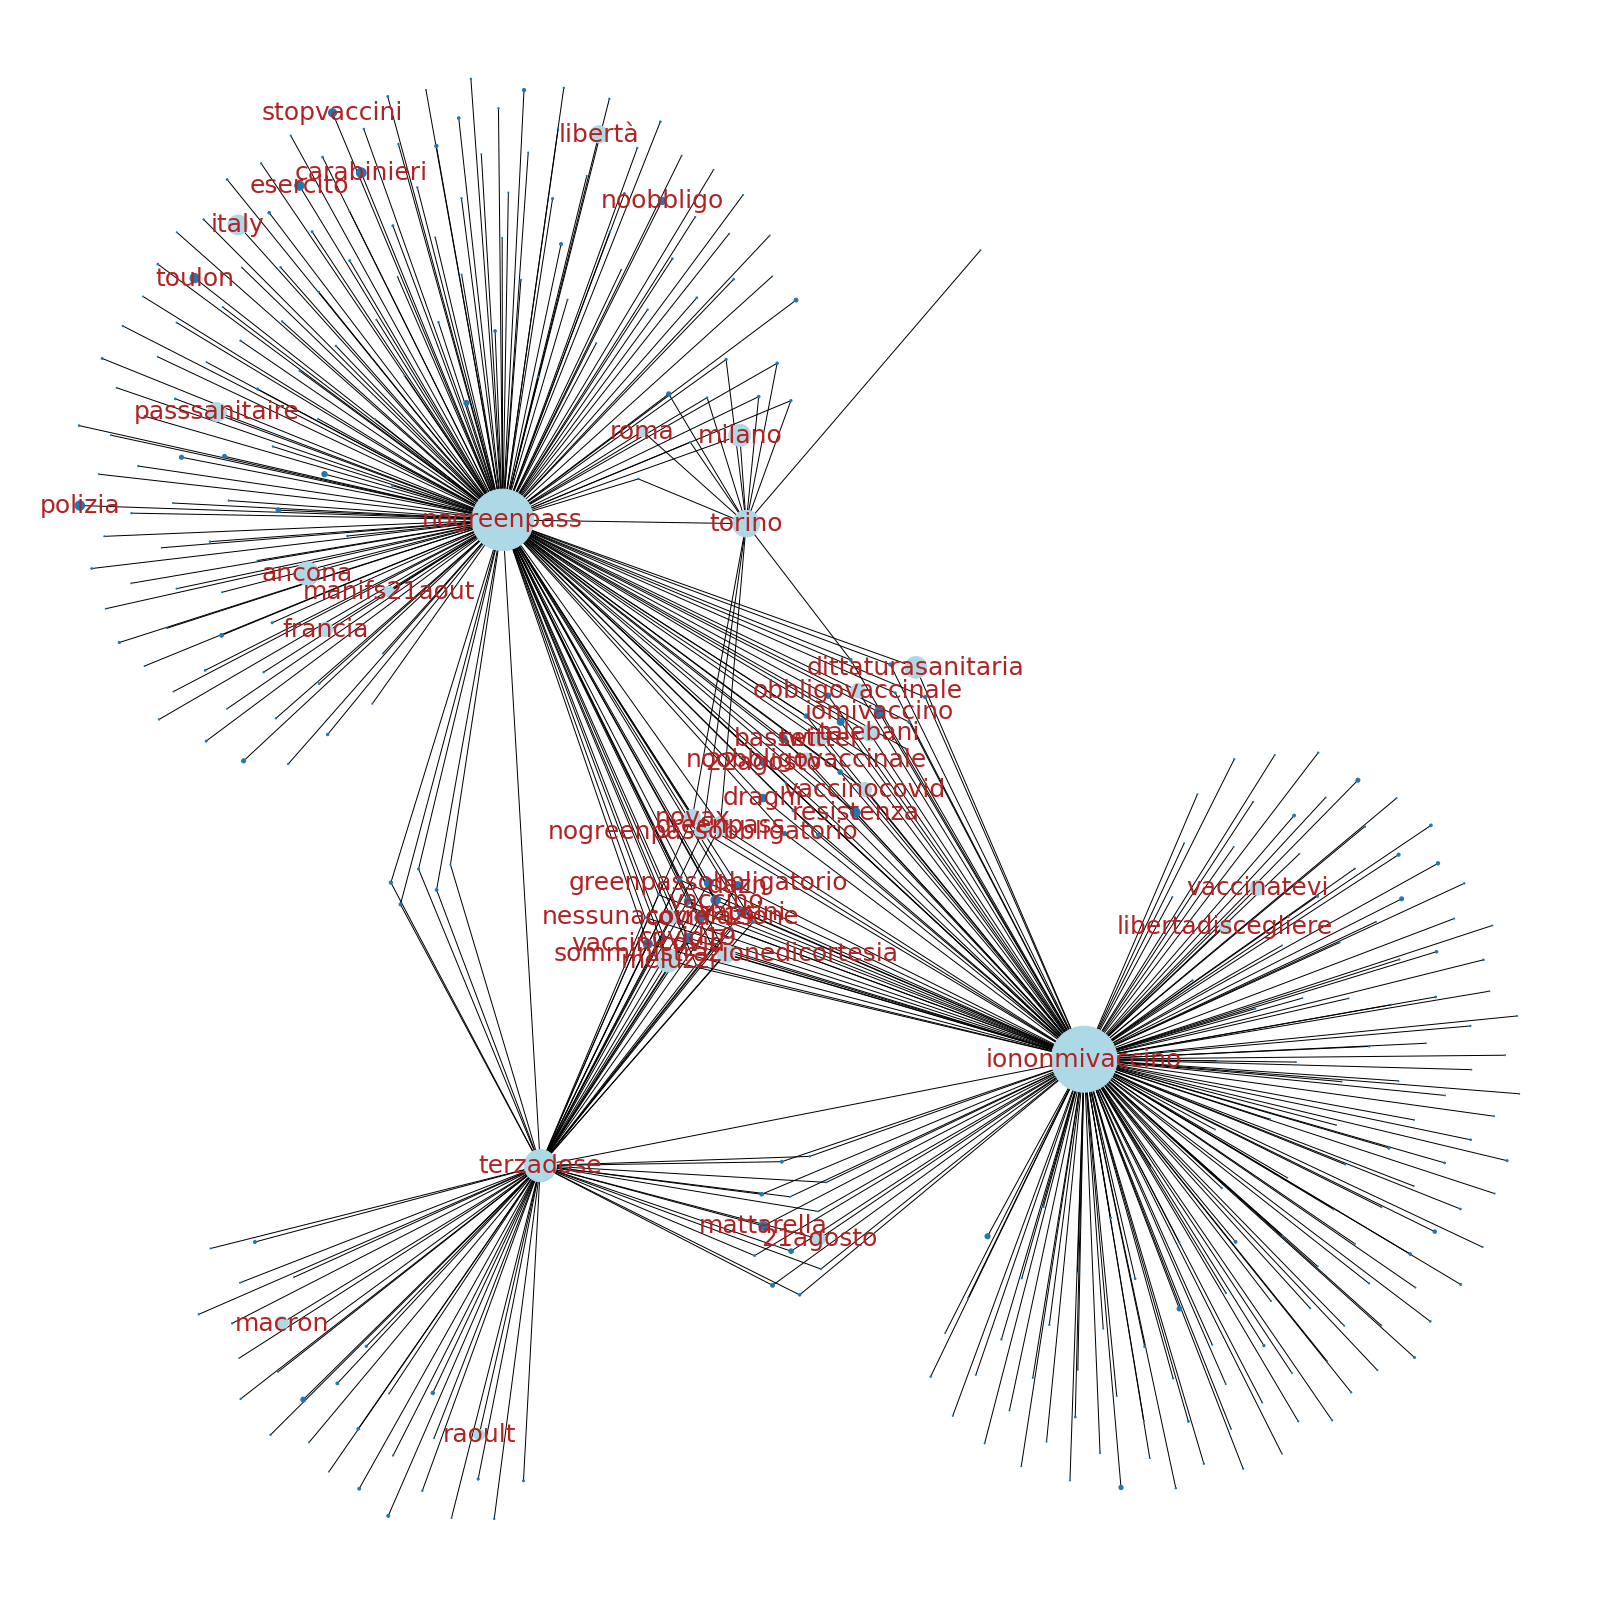

In [7]:
freq_distrib_hash = nlp.frequency_dist(tweet_df, obj ='hash')
graph_hash = graph_filtered_dist(df=unique_df, distrib=freq_distrib_hash, thresold=600, obj='hash')
NetworkPlot(graph= graph_hash, frequency_dist=freq_distrib_hash, label_thresold=50, color_thresold=100).plot()

In [6]:
freq_distrib_hash.most_common()

[('iononmivaccino', 4341),
 ('nogreenpass', 3789),
 ('terzadose', 1035),
 ('torino', 711),
 ('ancona', 545),
 ('meluzzi', 519),
 ('milano', 481),
 ('montagnier', 479),
 ('dittaturasanitaria', 469),
 ('italy', 394),
 ('greenpass', 367),
 ('passsanitaire', 355),
 ('somministrazionedicortesia', 338),
 ('libertà', 298),
 ('talebani', 263),
 ('nogreenpassobbligatorio', 260),
 ('novax', 255),
 ('vaccinatevi', 221),
 ('twitter', 220),
 ('obbligovaccinale', 206),
 ('francia', 206),
 ('nessunacorrelazione', 195),
 ('governo', 190),
 ('vaccinocovid', 187),
 ('noobbligovaccinale', 175),
 ('macron', 169),
 ('nizza', 166),
 ('21agosto', 158),
 ('fabriziochiodo', 141),
 ('libertadiscegliere', 133),
 ('raoult', 120),
 ('roma', 119),
 ('marsiglia', 119),
 ('11settembre', 109),
 ('manifs21aout', 104),
 ('covid_19', 98),
 ('carabinieri', 95),
 ('resistenza', 94),
 ('iomivaccino', 89),
 ('vaccini', 88),
 ('polizia', 88),
 ('toulon', 87),
 ('esercito', 87),
 ('vaccino', 85),
 ('covid19', 84),
 ('vaccinico